# Install MedMNIST

In [1]:
!pip install medmnist --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 668.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.7 MB/s eta 0:00:00


# Load and Explore PathMNIST


In [2]:
import medmnist
from medmnist import INFO
from medmnist import PathMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid

In [3]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
torch.manual_seed(42)

data_flag = 'pathmnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = DataClass(split='train', transform=transform, download=True)
test_dataset = DataClass(split='test', transform=transform, download=True)

batch_size = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

images, labels = next(iter(train_loader))
print(f"Train batch shape: {images.shape}, Labels shape: {labels.shape}")

100%|██████████| 206M/206M [00:58<00:00, 3.53MB/s]


Train batch shape: torch.Size([128, 3, 28, 28]), Labels shape: torch.Size([128, 1])


# Visualize sample images from PathMNIST


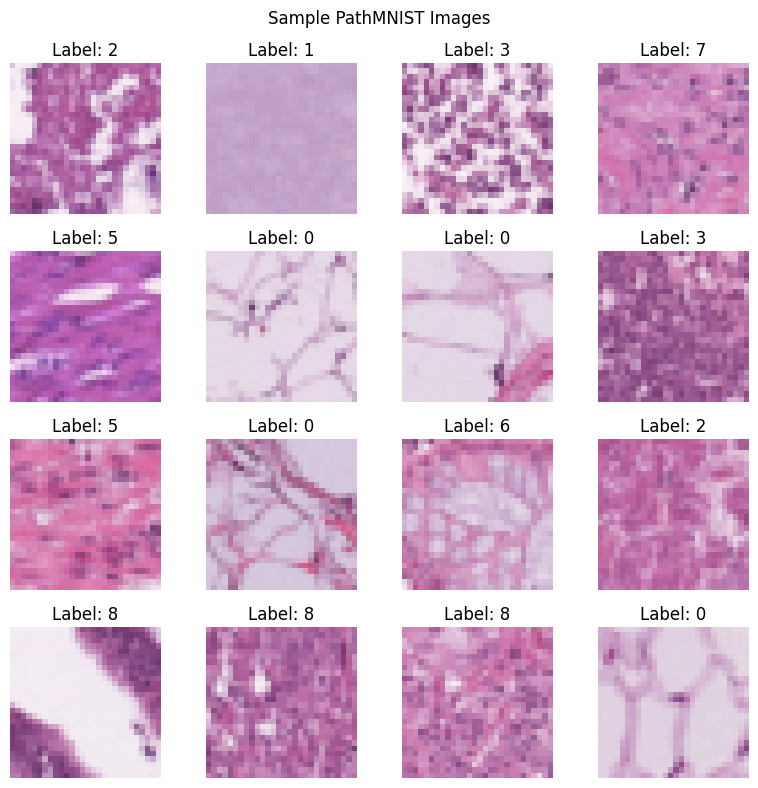

In [5]:
def unnormalize(img):
    img = img * 0.5 + 0.5
    return img

plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    img = unnormalize(images[i])
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f"Label: {int(labels[i])}")
    plt.axis("off")
plt.suptitle("Sample PathMNIST Images")
plt.tight_layout()
plt.show()


# DCGAN Discriminator


In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

discriminator = Discriminator().to(device)
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=6272, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


#DCGAN Generator


In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU(True),

            nn.Unflatten(1, (128, 7, 7)),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

generator = Generator().to(device)
print(generator)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=6272, bias=True)
    (1): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Unflatten(dim=1, unflattened_size=(128, 7, 7))
    (4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): Tanh()
  )
)


# Training Setup

In [8]:
latent_dim = 100
lr = 0.0002
num_epochs = 50

loss_function = nn.BCELoss()

optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
print("Training hyperparameters set.")

Training hyperparameters set.


# Train DCGAN on PathMNIST


In [9]:
for epoch in range(num_epochs):
    for batch_idx, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        real_labels = torch.ones((batch_size, 1)).to(device)

        noise = torch.randn((batch_size, latent_dim)).to(device)
        fake_images = generator(noise)
        fake_labels = torch.zeros((batch_size, 1)).to(device)

        outputs_real = discriminator(real_images)
        outputs_fake = discriminator(fake_images.detach())
        loss_d_real = loss_function(outputs_real, real_labels)
        loss_d_fake = loss_function(outputs_fake, fake_labels)
        loss_d = loss_d_real + loss_d_fake

        discriminator.zero_grad()
        loss_d.backward()
        optimizer_d.step()

        noise = torch.randn((batch_size, latent_dim)).to(device)
        fake_images = generator(noise)
        outputs = discriminator(fake_images)
        loss_g = loss_function(outputs, real_labels)

        generator.zero_grad()
        loss_g.backward()
        optimizer_g.step()

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] | Batch [{batch_idx}] | Loss D: {loss_d.item():.4f} | Loss G: {loss_g.item():.4f}")


Epoch [1/50] | Batch [0] | Loss D: 1.5570 | Loss G: 0.9926
Epoch [1/50] | Batch [100] | Loss D: 0.1344 | Loss G: 3.9018
Epoch [1/50] | Batch [200] | Loss D: 0.1150 | Loss G: 3.3315
Epoch [1/50] | Batch [300] | Loss D: 0.5624 | Loss G: 1.6427
Epoch [1/50] | Batch [400] | Loss D: 0.3108 | Loss G: 2.9838
Epoch [1/50] | Batch [500] | Loss D: 0.4561 | Loss G: 1.9451
Epoch [1/50] | Batch [600] | Loss D: 0.2007 | Loss G: 2.3143
Epoch [1/50] | Batch [700] | Loss D: 0.1560 | Loss G: 3.0477
Epoch [2/50] | Batch [0] | Loss D: 0.2439 | Loss G: 2.9851
Epoch [2/50] | Batch [100] | Loss D: 0.2556 | Loss G: 3.3905
Epoch [2/50] | Batch [200] | Loss D: 0.0934 | Loss G: 3.4562
Epoch [2/50] | Batch [300] | Loss D: 0.0851 | Loss G: 4.4119
Epoch [2/50] | Batch [400] | Loss D: 0.1315 | Loss G: 4.4373
Epoch [2/50] | Batch [500] | Loss D: 0.2142 | Loss G: 2.7922
Epoch [2/50] | Batch [600] | Loss D: 0.1126 | Loss G: 3.7004
Epoch [2/50] | Batch [700] | Loss D: 0.1865 | Loss G: 2.7951
Epoch [3/50] | Batch [0] | L

# Generate and Visualize Fake PathMNIST Images


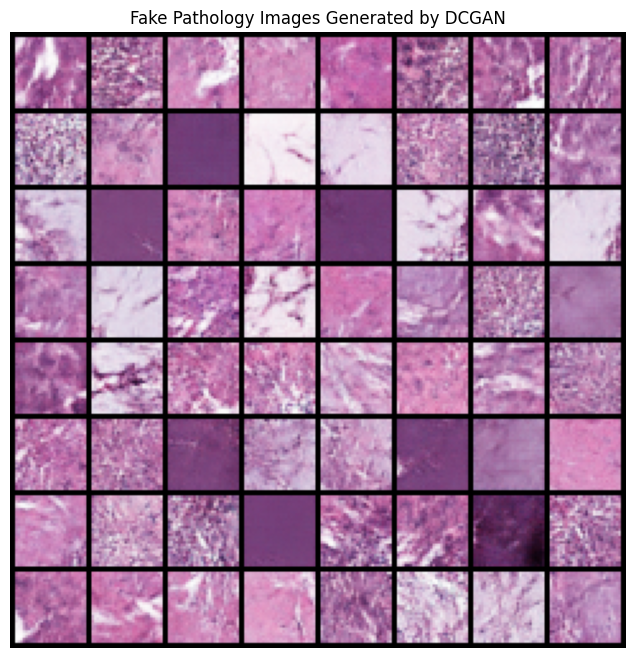

In [10]:
generator.eval()

with torch.no_grad():
    noise = torch.randn(64, latent_dim).to(device)
    fake_images = generator(noise).detach().cpu()

def unnormalize(img):
    return (img + 1) / 2
fake_images = unnormalize(fake_images)

grid = make_grid(fake_images, nrow=8, padding=2)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.title("Fake Pathology Images Generated by DCGAN")
plt.axis("off")
plt.show()